In [59]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-03-31 18:41:29'

# wip

In [60]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
%matplotlib inline

In [61]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    })

# some irrelavant config
#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [62]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False, gc2=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='haseeb',
                                            password=os.environ['gcpswd'],
                                            host='35.203.89.152',
                                            database=db_name)
            elif gc2:
                self.conn = mariadb.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [63]:
pd.set_option("display.max_columns", None)
pd.set_option('max_rows', 180)

db1 = DbAccessor('hshah1_0072_animal_learning_corr', cfg_primary_key="run", timestep_col_name="step", local=True, gc=False)

In [64]:
pd.read_sql(f'select * from runs', db1.conn)

,features,freq,lambda,name,run,seed,start,step_size,steps,width
0,10,100000000,0.999,0072_animal_learning_corr,0,0,0,0.0009,5200000,10
1,10,100000000,0.999,0072_animal_learning_corr,1,1,0,0.0009,5200000,10
2,10,100000000,0.999,0072_animal_learning_corr,2,2,0,0.0009,5200000,10
3,10,100000000,0.999,0072_animal_learning_corr,3,3,0,0.0009,5200000,10
4,10,100000000,0.999,0072_animal_learning_corr,4,4,0,0.0009,5200000,10
5,10,100000000,0.999,0072_animal_learning_corr,5,5,0,0.0009,5200000,10
6,10,100000000,0.999,0072_animal_learning_corr,6,6,0,0.0009,5200000,10
7,10,100000000,0.999,0072_animal_learning_corr,7,7,0,0.0009,5200000,10
8,10,100000000,0.999,0072_animal_learning_corr,8,8,0,0.0009,5200000,10
9,10,100000000,0.999,0072_animal_learning_corr,9,9,0,0.0009,5200000,10


In [119]:
db2 = DbAccessor('hshah1_0073_animal_learning_corr_tbptt', cfg_primary_key="run", timestep_col_name="step", local=True, gc=False)
pd.read_sql(f'select * from runs', db2.conn)

,features,lambda,name,run,seed,step_size,steps,truncation
0,10,0.999,0073_animal_learning_corr_tbptt,0,0,0.2,5200000,27
1,10,0.999,0073_animal_learning_corr_tbptt,1,1,0.2,5200000,27
2,10,0.999,0073_animal_learning_corr_tbptt,2,2,0.2,5200000,27
3,10,0.999,0073_animal_learning_corr_tbptt,3,3,0.2,5200000,27
4,10,0.999,0073_animal_learning_corr_tbptt,4,4,0.2,5200000,27
5,10,0.999,0073_animal_learning_corr_tbptt,5,5,0.2,5200000,27
6,10,0.999,0073_animal_learning_corr_tbptt,6,6,0.2,5200000,27
7,10,0.999,0073_animal_learning_corr_tbptt,7,7,0.2,5200000,27
8,10,0.999,0073_animal_learning_corr_tbptt,8,8,0.2,5200000,27
9,10,0.999,0073_animal_learning_corr_tbptt,9,9,0.2,5200000,27


In [77]:
features = pd.read_sql(f'select * from network_state where run!=4', db1.conn)

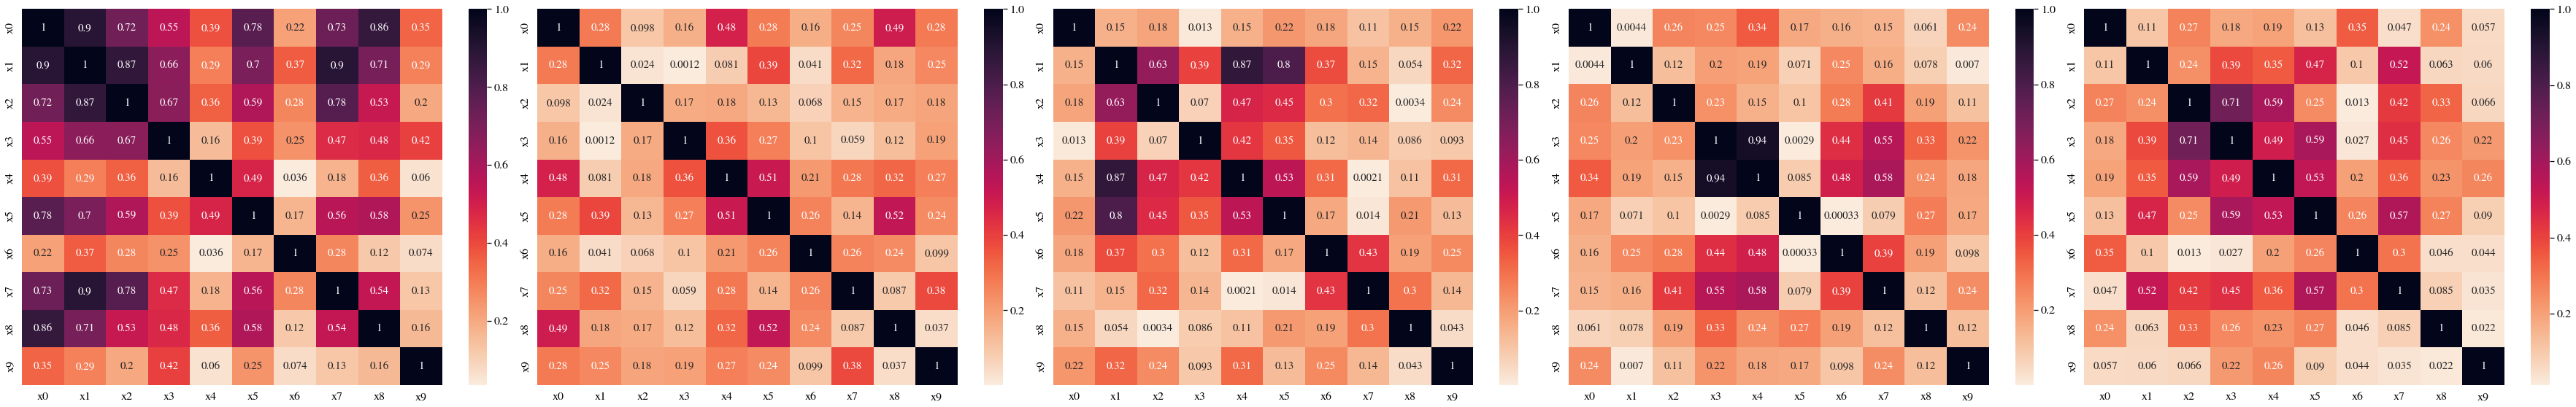

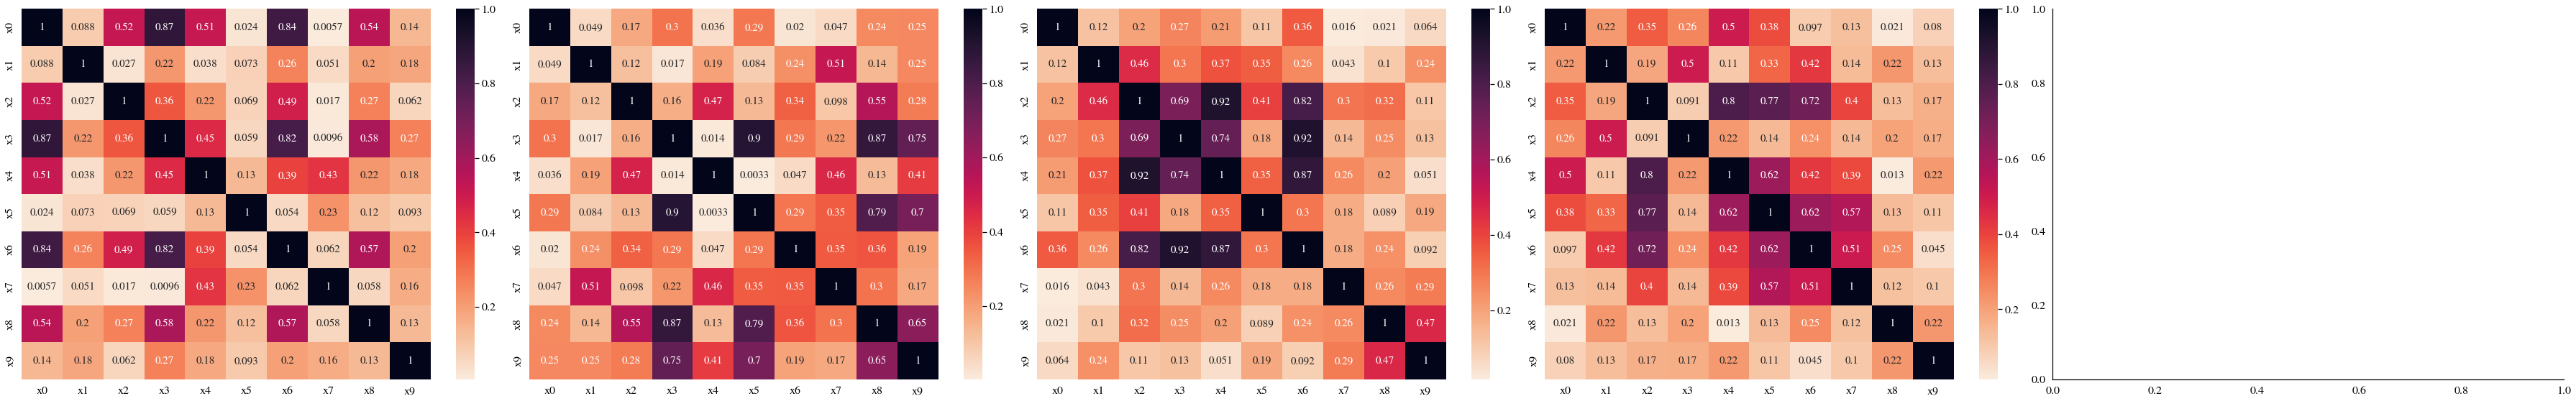

In [117]:
fig, axs = plt.subplots(1,5, figsize=(50,8))
i = 0
for run in [0,1,2,3,5]:
    features = pd.read_sql(f'select * from network_state where run={run}', db1.conn)
    corr = abs(features.iloc[:,2:12].corr())
    sns.heatmap(corr, annot=True, cmap=sns.cm.rocket_r, ax=axs[i])
    i = i + 1

fig, axs = plt.subplots(1,5, figsize=(50,8))

i = 0
for run in [6,7,8,9]:
    features = pd.read_sql(f'select * from network_state where run={run}', db1.conn)
    corr = abs(features.iloc[:,2:12].corr())
    sns.heatmap(corr, annot=True, cmap=sns.cm.rocket_r, ax=axs[i])
    i = i + 1
plt.show()



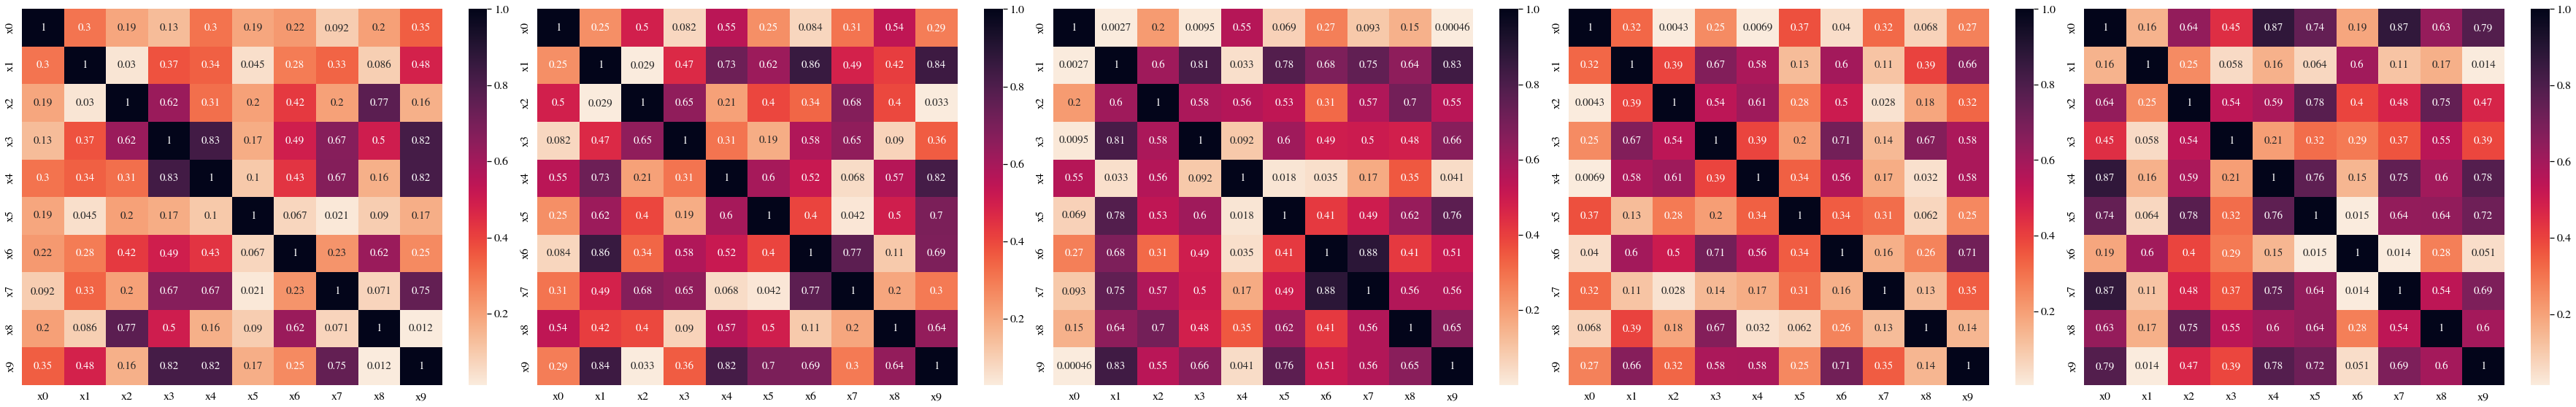

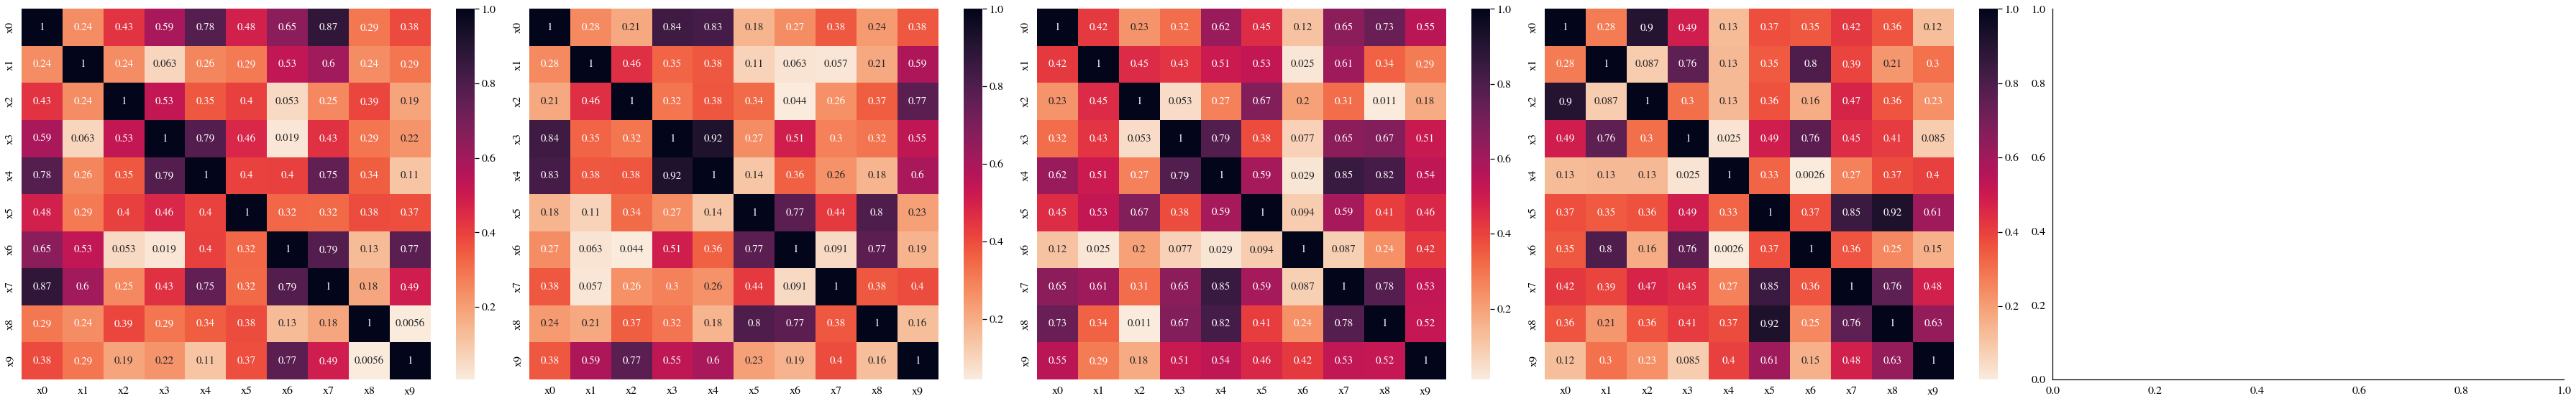

In [120]:
fig, axs = plt.subplots(1,5, figsize=(50,8))
i = 0
for run in [0,1,2,3,5]:
    features = pd.read_sql(f'select * from network_state where run={run}', db2.conn)
    corr = abs(features.iloc[:,2:12].corr())
    sns.heatmap(corr, annot=True, cmap=sns.cm.rocket_r, ax=axs[i])
    i = i + 1

fig, axs = plt.subplots(1,5, figsize=(50,8))

i = 0
for run in [6,7,8,9]:
    features = pd.read_sql(f'select * from network_state where run={run}', db2.conn)
    corr = abs(features.iloc[:,2:12].corr())
    sns.heatmap(corr, annot=True, cmap=sns.cm.rocket_r, ax=axs[i])
    i = i + 1
plt.show()

